# Data Science Pipeline: Prediction of Food Delivery Times

This notebook contains code that covers the entire data science pipeline, from preprocessing to the construction of a supervised model for predicting food delivery times based on various influencing factors.

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [44]:
# Loading the data set
raw = pd.read_csv("../data/Food_Delivery_Times.csv")
raw.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


## EDA

In [45]:
# Getting to quickly know the data
print(raw.info())
print("****************************************************")

# Checking for null values
print(raw.isna().sum())
print("****************************************************")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB
None
****************************************************
Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_

In [46]:
# Removing `order_id` variable
df = raw.drop(columns = ["Order_ID"], inplace = False)
df.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68


### Numerical data

In [47]:
# Summary statistics of numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Distance_km,1000.0,10.059970,5.696656,0.59,5.105,10.19,15.0175,19.99
Preparation_Time_min,1000.0,16.982000,7.204553,5.00,11.000,17.00,23.0000,29.00
Courier_Experience_yrs,970.0,4.579381,2.914394,0.00,2.000,5.00,7.0000,9.00
Delivery_Time_min,1000.0,56.732000,22.070915,8.00,41.000,55.50,71.0000,153.00


In [48]:
# List of numerical variables
col_num = df.select_dtypes(include='number').columns
col_num

Index(['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs',
       'Delivery_Time_min'],
      dtype='object')

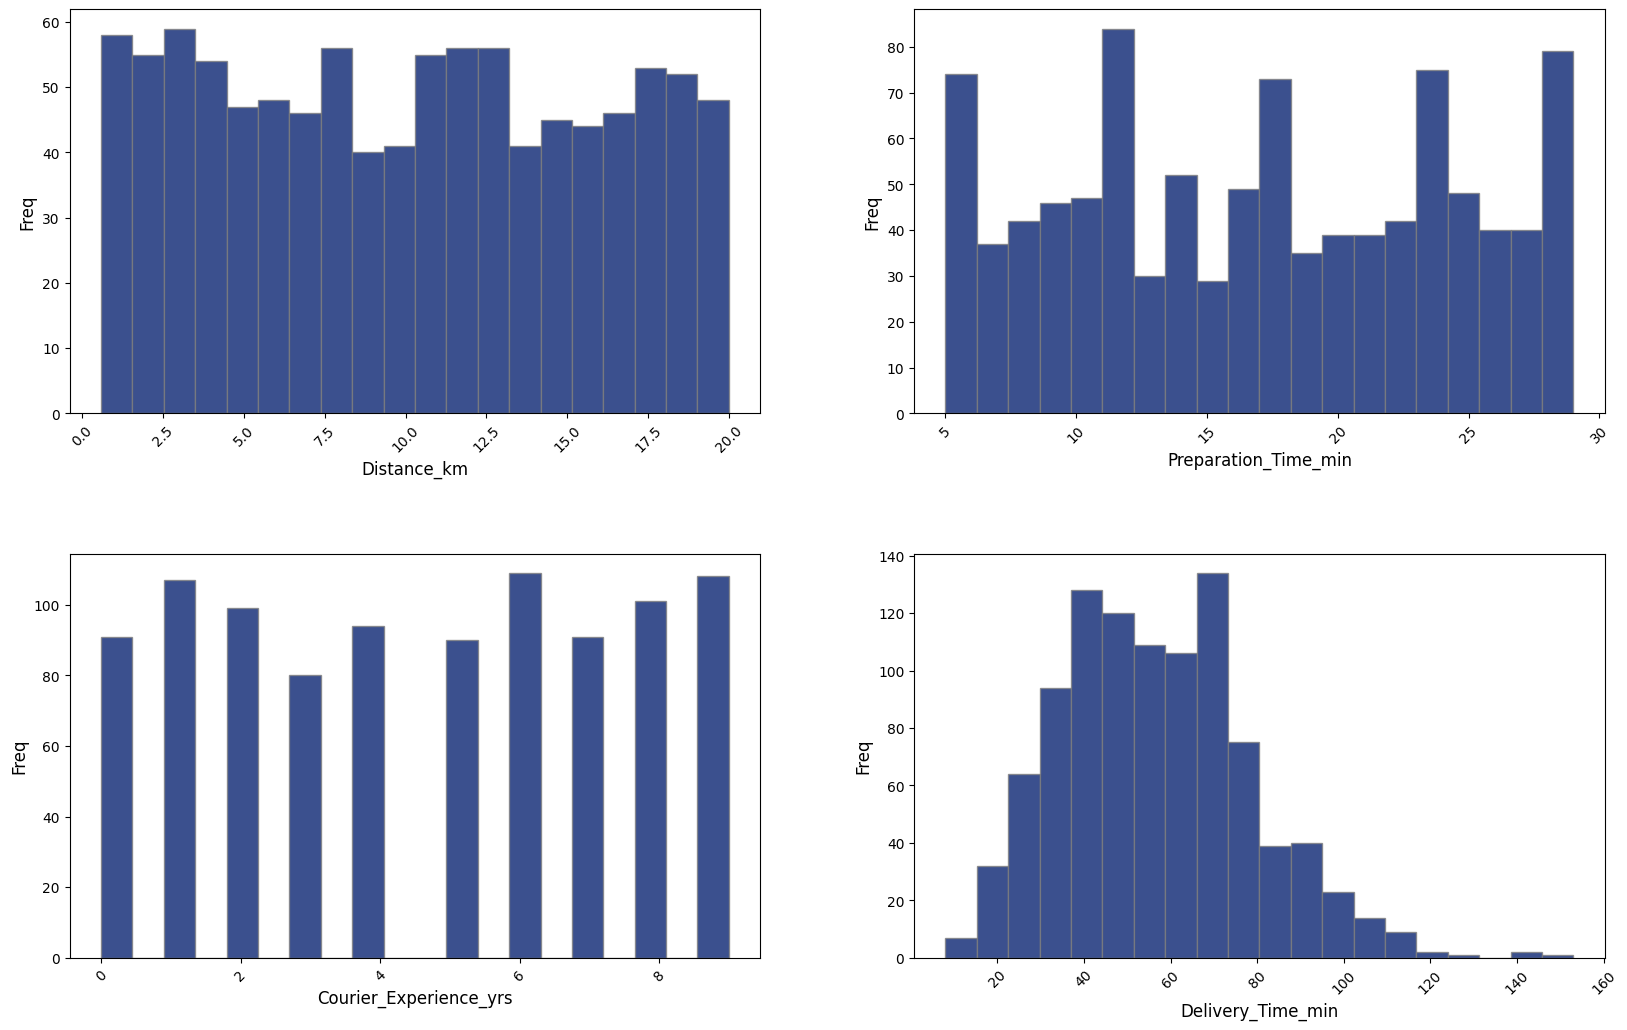

In [49]:
# HISTOGRAMS
num_plots = len(col_num) # Number of plots
num_cols = 2  # Number of columns in the grid layout
num_rows = (num_plots - 1) // num_cols + 1 # Number of rows in the grid layout

# Creating subplots
fig, axs = plt.subplots(num_rows, num_cols,
                        figsize=(18, 6*num_rows))

fig.tight_layout(pad=8)  # Spacing between subplots

# Iterate over columns and create histograms
for i, column in enumerate(col_num): # pairs containing the index and value
    # i holds the index of the column, and column the column name.

    ax = axs[i // num_cols, #  row index of subplot
              i % num_cols] # column index of subplot
    ax.hist(df[column],
            bins=20,
            stacked=True,
            edgecolor="grey",
            color="#0A2472",
            alpha=0.8)
    ax.set_xlabel(column)
    ax.set_ylabel("Freq")
    ax.set_xlabel(column, size=12)
    ax.set_ylabel("Freq", size=12)
    ax.tick_params(axis='x', rotation=45)  # Rotation of x-axis labels

# Condition to remove empty subplots if the number of plots is not a multiple of num_cols
if num_plots % num_cols != 0: # if reminder is not equal to 0
    for j in range(num_plots % num_cols, num_cols):
        fig.delaxes(axs[num_rows - 1, j])

plt.show()

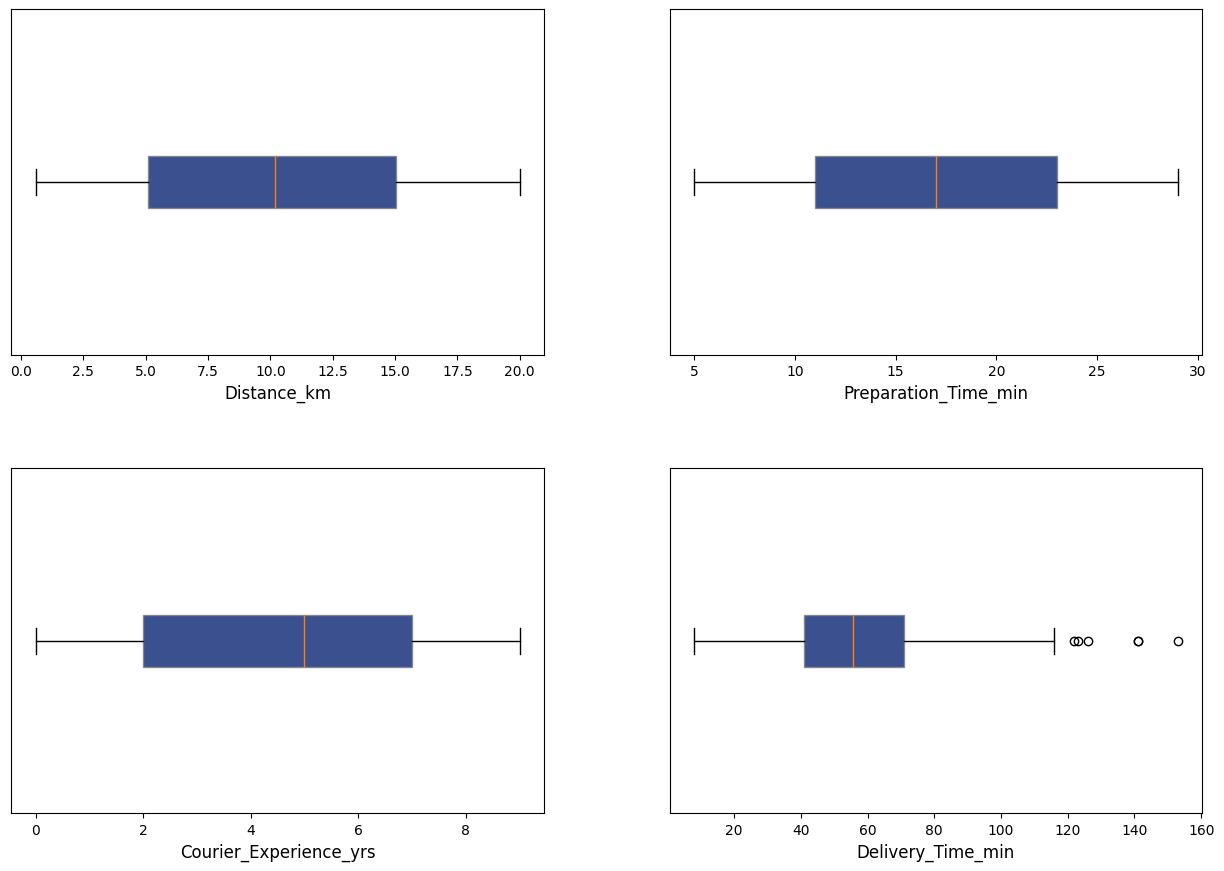

In [50]:
# BOX PLOTS
num_plots = len(col_num) # Number of plots
num_cols = 2  # Number of columns in the grid layout
num_rows = (num_plots - 1) // num_cols + 1 # Number of rows in the grid layout

# Creating subplots
fig, axs = plt.subplots(num_rows, num_cols,
                        figsize=(14, 10))

fig.tight_layout(pad=6)  # Spacing between subplots

for i, column in enumerate(col_num):
    ax = axs[i // num_cols, i % num_cols]
    data = df[column].dropna() # to render boxplot of variables with NAs
    ax.boxplot(data, 
               vert=False, 
               patch_artist=True,
               boxprops=dict(facecolor="#0A2472", edgecolor="grey", alpha=0.8))
    ax.set_xlabel(column, size=12)
    # Clear y-ticks
    ax.set_yticks([])

# Condition to remove empty subplots if the number of plots is not a multiple of num_cols
if num_plots % num_cols != 0: 
    for j in range(num_plots % num_cols, num_cols):
        fig.delaxes(axs[num_rows - 1, j])

plt.show()

### Categorical Data

In [51]:
# Summary statistics of categorical variables
df.describe(include=object).T

,count,unique,top,freq
Weather,970,5,Clear,470
Traffic_Level,970,3,Medium,390
Time_of_Day,970,4,Morning,308
Vehicle_Type,1000,3,Bike,503


In [52]:
# List of numerical variables
col_cat = df.select_dtypes(include=object).columns
col_cat

Index(['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type'], dtype='object')

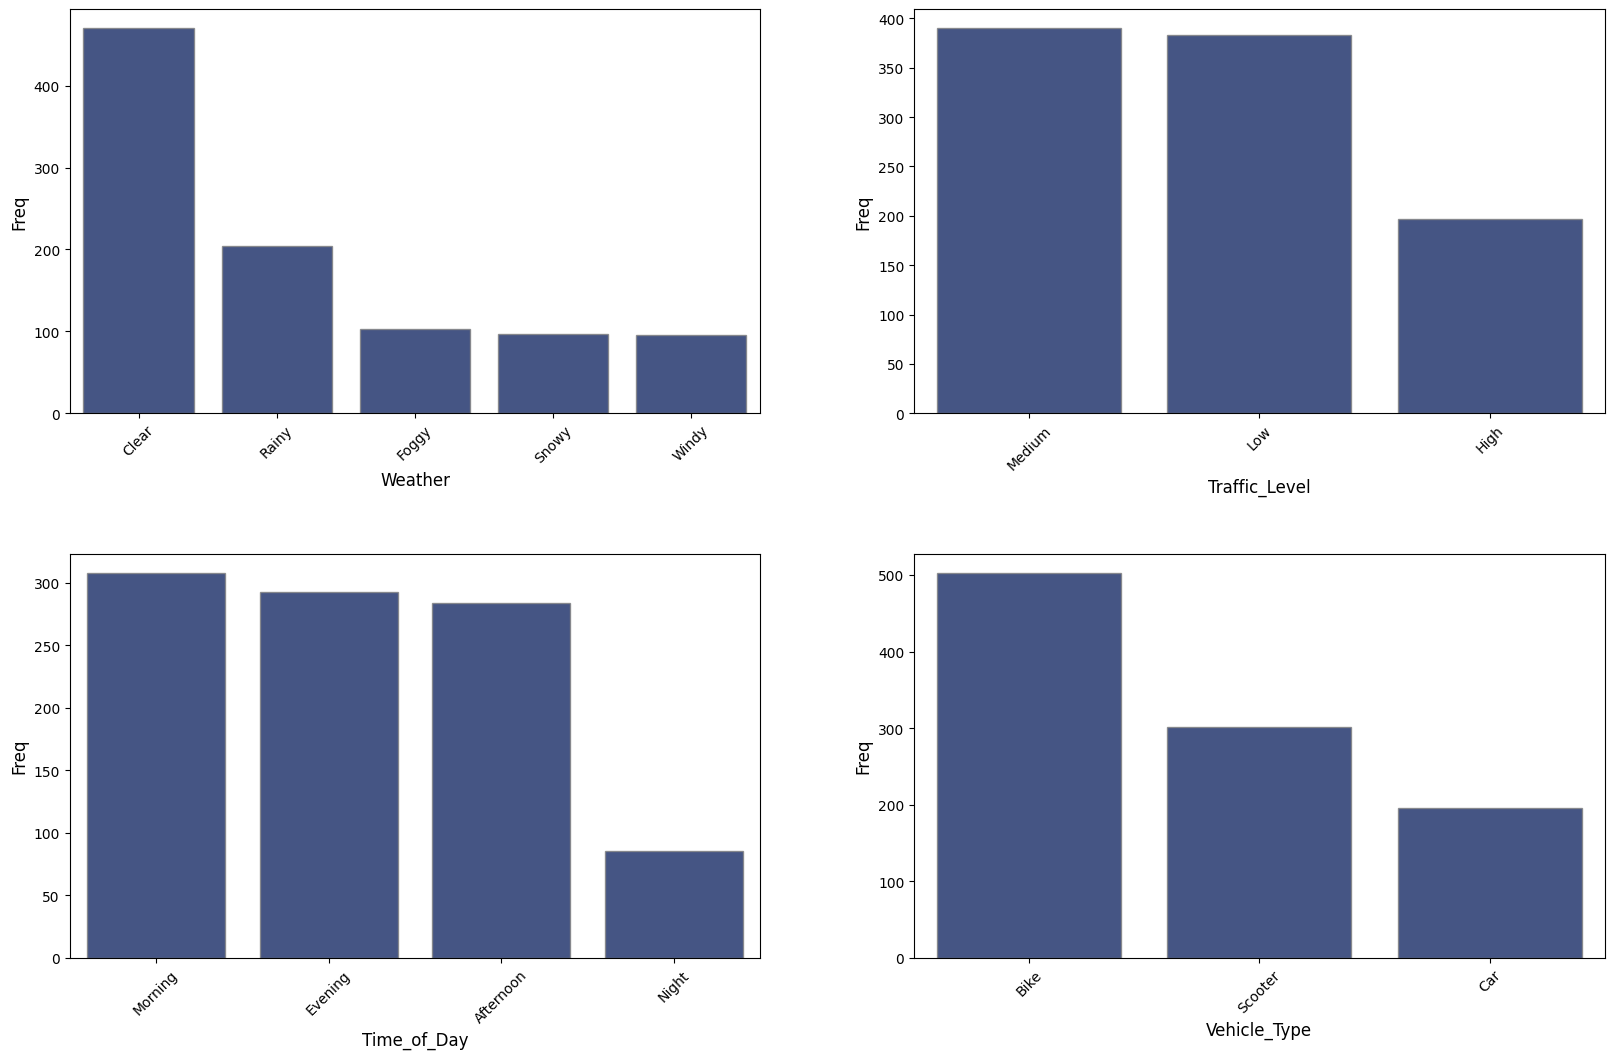

In [53]:
# BAR PLOTS
num_plots = len(col_cat) # Number of plots
num_cols = 2  # Number of columns in the grid layout
num_rows = (num_plots - 1) // num_cols + 1 # Number of rows in the grid layout

# Creating subplots
fig, axs = plt.subplots(num_rows, num_cols,
                        figsize=(18, 6*num_rows))

fig.tight_layout(pad=8)  # Spacing between subplots

for i, column in enumerate(col_cat):
    ax = axs[i // num_cols,
              i % num_cols]
    sns.countplot(x=column,
                  data=df,
                  color="#0A2472",
                  edgecolor="grey",
                  alpha=0.8,
                  order=df[column].value_counts().index,
                  ax=ax)
    ax.set_xlabel(column, size=12)
    ax.set_ylabel("Freq", size=12)
    ax.tick_params(axis="x", rotation=45)

if num_plots % num_cols != 0:
    for j in range(num_plots % num_cols, num_cols):
        fig.delaxes(axs[num_rows - 1, j])

plt.show()

## Pre-processing

### Filling of NAs

In [54]:
# Categorical variables with NAs will be filled with mode
# Numerical variables with NAs will be filled with median 

for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        median_col = df[col].median()
        df[col] = df[col].fillna(median_col)
    else:
        mode_col = df[col].mode()[0]
        df[col] = df[col].fillna(mode_col)

# Checking for null values
df.isna().sum()

Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64

#### Encoding categorical variables

As part of the pre-processing stage, it is essential to distinguish between variables
- Order ID: nominal
- Distance_km: continuous
- Weather: nominal
- Traffic_Level: ordinal
- Time_of_Day: ordinal
- Vehicle_Type: nominal
- Preparation_Time_min: discrete (since it's whole numbers)
- Courier_Experience_yrs: discrete (since it's whole numbers)
- Delivery_Time_min: discrete (since it's whole numbers)

Nominal variables should be encoded using One-Hot encoding or **Dummy encoding**. Dummy encoding drops one of the coordinates, since it can be inferred from the other three.

In [55]:
# Establishing the correct order in ordinal variables
traffic_ord = ["Low", "Medium", "High"]
time_ord = ["Morning", "Afternoon", "Evening", "Night"]

# Transforming ordinal values to int
df["Traffic_Level_ord"] = df["Traffic_Level"].map({cat:i for i,cat in enumerate(traffic_ord, start=1)})
df["Time_of_Day_ord"] = df["Time_of_Day"].map({cat:i for i,cat in enumerate(time_ord, start=1)})

df.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Traffic_Level_ord,Time_of_Day_ord
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43,1,2
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84,2,3
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59,1,4
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37,2,2
4,19.03,Clear,Low,Morning,Bike,16,5.0,68,1,1


In [56]:
# List of nominal variables to be encoded
cols_nom = ["Weather", "Vehicle_Type"]

# Dummy variables: assigning numerical values and storing in another column
for x in cols_nom:
    df = pd.get_dummies(df, 
                        columns=[x],
                        drop_first=True, # dropping one level to avoid collinearity
                        dtype=int)
    
df.head()

,Distance_km,Traffic_Level,Time_of_Day,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Traffic_Level_ord,Time_of_Day_ord,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Vehicle_Type_Car,Vehicle_Type_Scooter
0,7.93,Low,Afternoon,12,1.0,43,1,2,0,0,0,1,0,1
1,16.42,Medium,Evening,20,2.0,84,2,3,0,0,0,0,0,0
2,9.52,Low,Night,28,1.0,59,1,4,1,0,0,0,0,1
3,7.44,Medium,Afternoon,5,1.0,37,2,2,0,1,0,0,0,1
4,19.03,Low,Morning,16,5.0,68,1,1,0,0,0,0,0,0


In [57]:
# Dropping unused columns
df_clean = df.drop(["Traffic_Level", "Time_of_Day"], axis=1)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Distance_km             1000 non-null   float64
 1   Preparation_Time_min    1000 non-null   int64  
 2   Courier_Experience_yrs  1000 non-null   float64
 3   Delivery_Time_min       1000 non-null   int64  
 4   Traffic_Level_ord       1000 non-null   int64  
 5   Time_of_Day_ord         1000 non-null   int64  
 6   Weather_Foggy           1000 non-null   int64  
 7   Weather_Rainy           1000 non-null   int64  
 8   Weather_Snowy           1000 non-null   int64  
 9   Weather_Windy           1000 non-null   int64  
 10  Vehicle_Type_Car        1000 non-null   int64  
 11  Vehicle_Type_Scooter    1000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 93.9 KB


In [58]:
# Rearranging columns as original
cols = [x for x in list(df_clean) if x != 'Delivery_Time_min'] + ['Delivery_Time_min']
df_clean = df_clean[cols]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Distance_km             1000 non-null   float64
 1   Preparation_Time_min    1000 non-null   int64  
 2   Courier_Experience_yrs  1000 non-null   float64
 3   Traffic_Level_ord       1000 non-null   int64  
 4   Time_of_Day_ord         1000 non-null   int64  
 5   Weather_Foggy           1000 non-null   int64  
 6   Weather_Rainy           1000 non-null   int64  
 7   Weather_Snowy           1000 non-null   int64  
 8   Weather_Windy           1000 non-null   int64  
 9   Vehicle_Type_Car        1000 non-null   int64  
 10  Vehicle_Type_Scooter    1000 non-null   int64  
 11  Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 93.9 KB


## Correlation Matrix

In [59]:
# Correlation matrix, chosen method: Spearman for non-linear correlation
matrix = df_clean.corr(method='spearman')
matrix = round(matrix, 2)

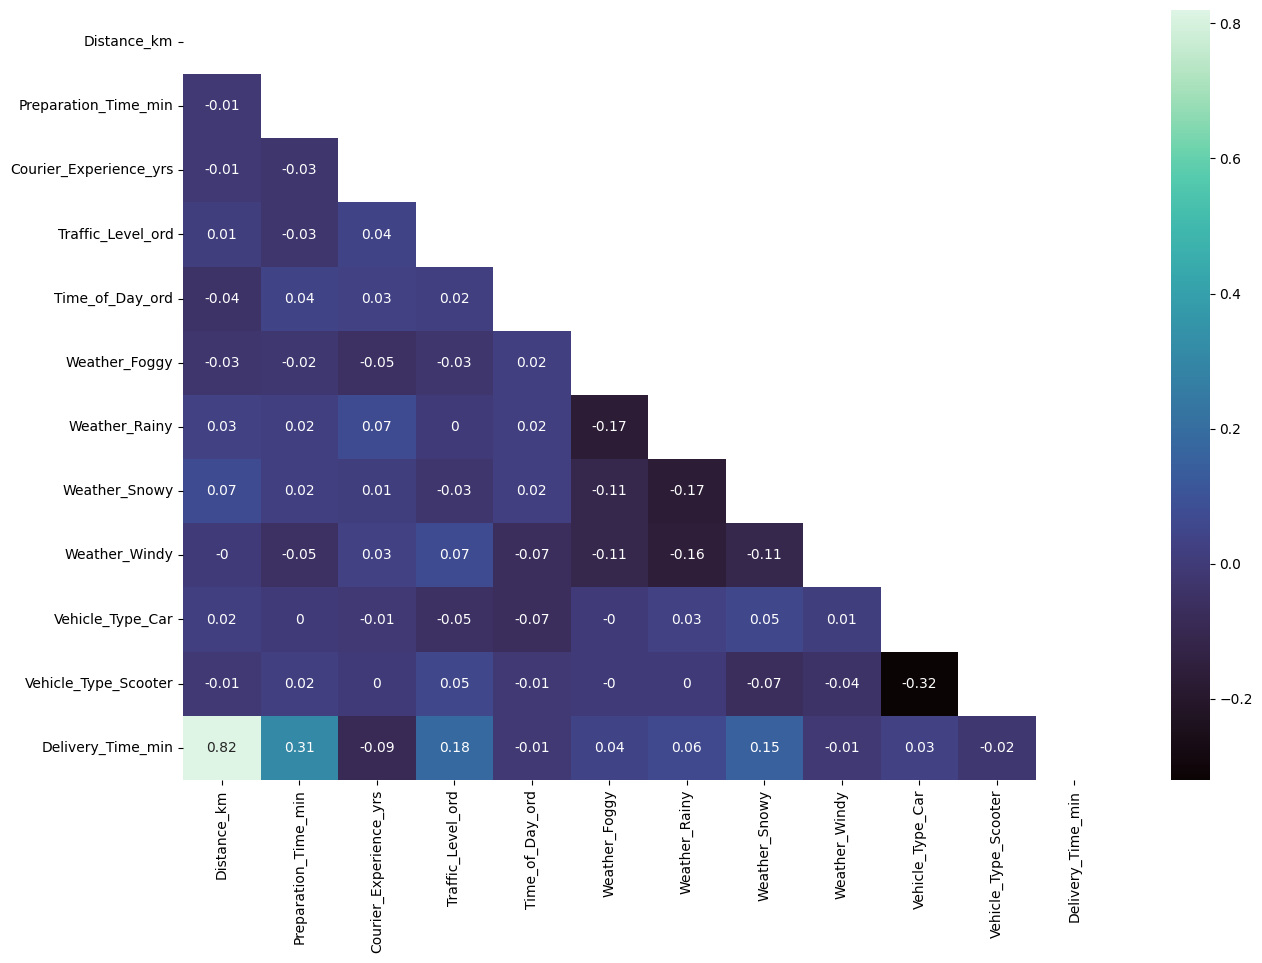

In [60]:
# Visualization of matrix with heatmap
plt.subplots(figsize=(15, 10))

# Creating a mask to hide the upper part of the matrix. It hides all the True values
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Final plot
sns.heatmap(matrix, 
            mask=mask,
            cmap="mako",
            annot=True)
plt.show()

## Feature Importance

Although the correlation matrix already provided hints about strong relationships amongst variables, the importance of each feature will be determined by Random Forest. The model calculates the average reduction in variance contributed by each feature across all the trees in the forest. A feature that causes a larger average reduction is considered more important (Gemini).

Randomized Search will be implemented to choose the best parameters because its much faster and efficient than Grid Search

In [61]:
# Splitting data set into X and y
X = df_clean.drop('Delivery_Time_min', axis=1)
y = df_clean["Delivery_Time_min"]

# Defining the grid to test on the model
param_dist = {
    "n_estimators":      [100, 200, 300], # no. of trees
    "max_depth":         [None, 6, 10, 15, 20], # max depth of tree
    "min_samples_split": [2, 5, 10], # min number of data points required to split a node in a tree
    "max_features":      ["sqrt", "log2", 1.0] # # how many features to consider when splitting. '1.0' is equivalent to all features
}

# Initializing the model and running Randomized Search
# Model
rf = RandomForestRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30, # try 30 different combinations of params
    cv=5, # cross-validation with a k of 5
    verbose=2,
    random_state=42,
    n_jobs=-1 # -1 uses all available CPU cores
)

# Fit the model to find the best parameters
random_search.fit(X, y)

# Get the Best Parameters
print("\nBest Parameters:")
print(random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Parameters:
{'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 15}


In [62]:
# Final model
best = random_search.best_params_
rf_final = RandomForestRegressor(
    **best,
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X, y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,15
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Distance_km               0.642685
Preparation_Time_min      0.148789
Courier_Experience_yrs    0.056718
Traffic_Level_ord         0.049359
Time_of_Day_ord           0.026361
Weather_Snowy             0.021613
Weather_Rainy             0.014868
Weather_Foggy             0.012426
Vehicle_Type_Scooter      0.010747
Vehicle_Type_Car          0.010430
Weather_Windy             0.006004
dtype: float64


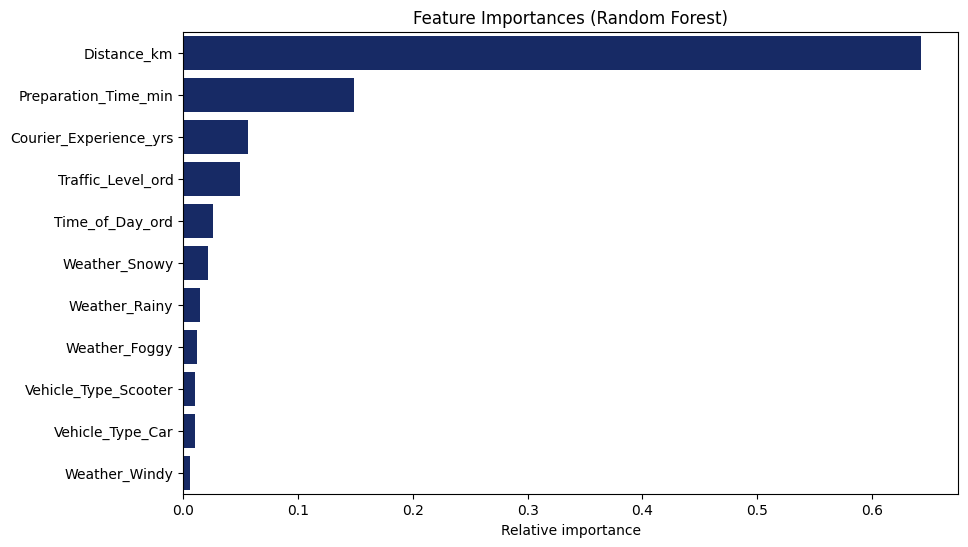

In [63]:
imp = pd.Series(rf_final.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

plt.figure(figsize=(10,6))
sns.barplot(
    x=imp.values, 
    y=imp.index, 
    color="#0A2472"
)
plt.xlabel("Relative importance")
plt.ylabel("")
plt.title("Feature Importances (Random Forest)")
plt.show()

## First Model: Linear Regression

### Standardization

In [64]:
def standardization(df, col):
    """
    Computes the z-score standardization with mean = 0 and std = 1

    Args:
        df: dataset
        col: features to standardize 
    
    Returns
        new columns with standardize values
    """
    ave = df[col].mean()
    std = df[col].std()

    df[f'{col}_std'] = df[col].apply(lambda x: (x-ave)/std)
    return df

In [65]:
l_linear = ["Distance_km",
            "Preparation_Time_min",
            "Courier_Experience_yrs",
            "Traffic_Level_ord",
            "Delivery_Time_min"
    ]

for x in l_linear:
    df_linear = standardization(df_clean, x)

df_linear.head()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Traffic_Level_ord,Time_of_Day_ord,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Vehicle_Type_Car,Vehicle_Type_Scooter,Delivery_Time_min,Distance_km_std,Preparation_Time_min_std,Courier_Experience_yrs_std,Traffic_Level_ord_std,Delivery_Time_min_std
0,7.93,12,1.0,1,2,0,0,0,1,0,1,43,-0.373898,-0.691507,-1.251046,-1.101661,-0.622176
1,16.42,20,2.0,2,3,0,0,0,0,0,0,84,1.116450,0.418902,-0.902759,0.251731,1.235472
2,9.52,28,1.0,1,4,1,0,0,0,0,1,59,-0.094787,1.529311,-1.251046,-1.101661,0.102760
3,7.44,5,1.0,2,2,0,1,0,0,0,1,37,-0.459914,-1.663115,-1.251046,0.251731,-0.894027
4,19.03,16,5.0,1,1,0,0,0,0,0,0,68,1.574613,-0.136303,0.142101,-1.101661,0.510536


### Chebyshev's theorem for anomaly detection

In [66]:
# Selecting only necessary columns
col_std = [f'{x}_std' for x in l_linear]

# Keeping the observations among -2 and 2 std. If none, the size of the data remains the same
for x in col_std:
    df_linear = df_linear[(df_linear[x] >= -2) & (df_linear[x] <= 2)]

print(f'The size of the data frame now is: {df_linear.index.size}')

The size of the data frame now is: 965


### Test set and Model

In [67]:
# Train and test sets
df_linear = df_linear[col_std]

X_train, X_test, y_train, y_test = train_test_split(
    df_linear.iloc[:, :-1], df_linear["Delivery_Time_min_std"], test_size=0.25, random_state=42
)

In [68]:
# Fitting linear regression to data
lr = LinearRegression()
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Model Performance and Diagnostic

In [69]:
# Generating predictions (y hat)
y_hat = lr.predict(X_test)

# Computting performance metrics
mse = mean_squared_error(y_test, y_hat)
mae = mean_absolute_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)

print(f"MSE  : {mse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {mse ** 0.5:.2f}")
print(f"R²   : {r2:.3f}")

MSE  : 0.12
MAE  : 0.27
RMSE : 0.34
R²   : 0.839


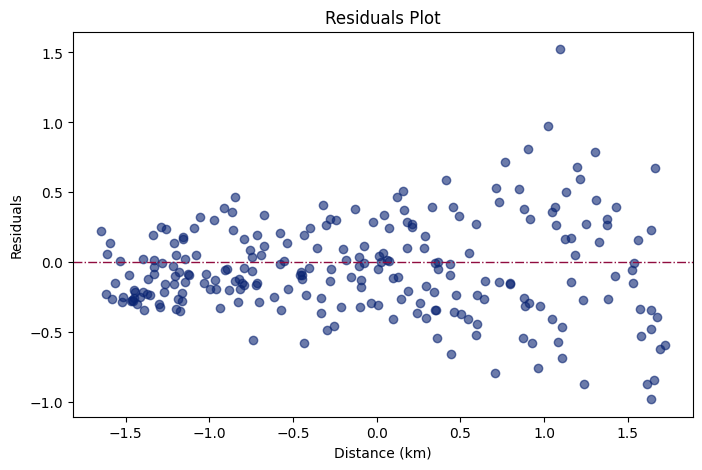

In [75]:
# Residuals plot
residuals = y_test - y_hat

plt.figure(figsize=(8, 5))
plt.scatter(X_test["Distance_km_std"], residuals, alpha=0.6, color="#0A2472")
plt.axhline(0, color="#900C3F", linestyle="dashdot", linewidth=1)
plt.xlabel("Distance (km)")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

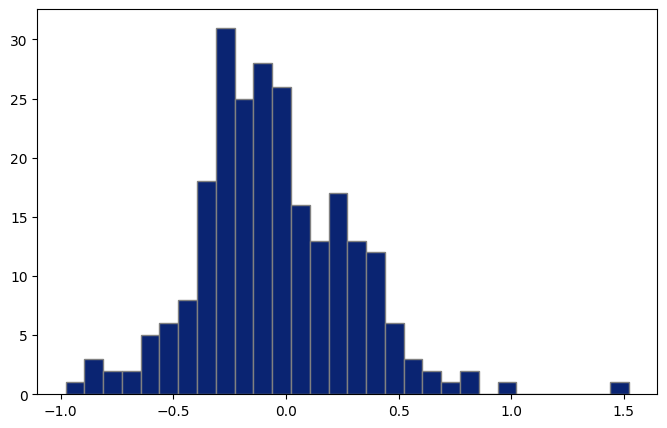

In [ ]:
# Histogram of residuals to check distribution
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor="grey", color="#0A2472")
plt.show()

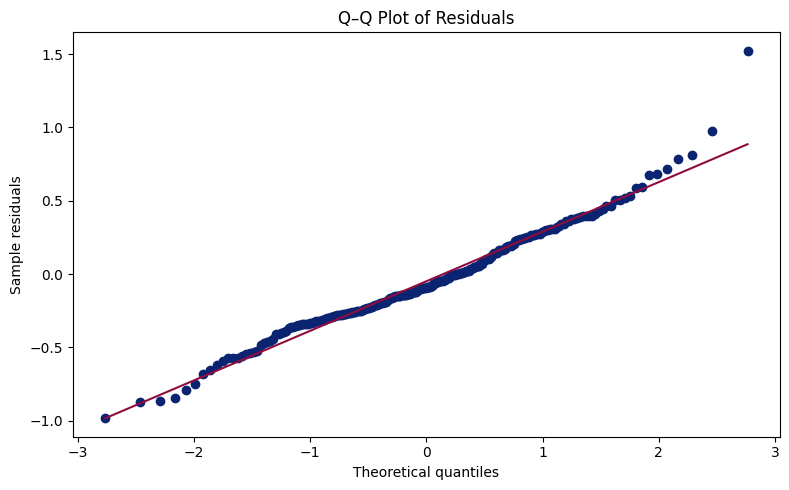

In [76]:
# Q-Q plot
fig, ax = plt.subplots(figsize=(8, 5))
stats.probplot(residuals, dist="norm", plot=ax)

pts = ax.get_lines()[0]
pts.set_color("#0A2472")
ax.get_lines()[1].set_color("#900C3F") # reference line red
ax.set_title("Q–Q Plot of Residuals")
ax.set_ylabel("Sample residuals")
ax.set_xlabel("Theoretical quantiles")

plt.tight_layout()
plt.show()

## Second Model: Random Forest

### Test Set and Model

In [ ]:
# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_clean[["Distance_km",
              "Preparation_Time_min",
              "Courier_Experience_yrs",
              "Traffic_Level_ord"]], 
    df_clean["Delivery_Time_min"], 
    test_size=0.25, 
    random_state=42
)

In [ ]:
# Defining the grid to test on the model
param_dist = {
    "n_estimators":      [100, 200, 300, 400], # no. of trees
    "max_depth":         [None, 5, 10, 15, 20, 25], # max depth of tree
    "min_samples_split": [2, 5, 10, 15], # min number of data points required to split a node in a tree
    "max_features":      ["sqrt", "log2", 1.0] # # how many features to consider when splitting. '1.0' is equivalent to all features
}

# Initializing the model and running Randomized Search
# Model
rf = RandomForestRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=40, # try 40 different combinations of params
    cv=5, # cross-validation with a k of 5
    verbose=2,
    random_state=42,
    n_jobs=-1 # -1 uses all available CPU cores
)

# Fit the model to find the best parameters
random_search.fit(
    df_clean[["Distance_km",
              "Preparation_Time_min",
              "Courier_Experience_yrs",
              "Traffic_Level_ord"]], 
    df_clean["Delivery_Time_min"])

# Get the Best Parameters
print("\nBest Parameters:")
print(random_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best Parameters:
{'n_estimators': 200, 'min_samples_split': 15, 'max_features': 'sqrt', 'max_depth': 15}


In [ ]:
# Final RF model
best = random_search.best_params_
rf = RandomForestRegressor(
    **best,
    random_state=42,
    n_jobs=-1
)

# Fitting training set
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,15
,min_samples_split,15
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Model Performance and Diagnostic

In [ ]:
# Generating predictions (y hat)
y_hat = rf.predict(X_test)

# Computting performance metrics
mse_rf = mean_squared_error(y_test, y_hat)
mae_rf = mean_absolute_error(y_test, y_hat)
rmse_rf = mse_rf ** 0.5

print(f"MSE : {mse_rf:.2f}")
print(f"MAE : {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")

MSE : 103.07
MAE : 7.18
RMSE: 10.15


## Third Model: XGBoost

In [ ]:
# Base model
xgb = XGBRegressor(objective="reg:squarederror", 
                   random_state=42, 
                   n_jobs=-1)

# Parameter grid
param_grid = {
    "n_estimators":      [100, 200, 300],
    "max_depth":         [3, 6, 9, 12, 15],
    "learning_rate":     [0.01, 0.1, 0.2],
    "subsample":         [0.6, 0.8, 1.0],
    "colsample_bytree":  [0.6, 0.8, 1.0]
}

# Grid search setup
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # minimize MSE
    cv=5,
    verbose=1,
    n_jobs=-1,
    return_train_score=False
)

# Fit the model
grid.fit(X_train, y_train)

print("Best CV MSE    :", -grid.best_score_)
print("Best parameters:", grid.best_params_)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Best CV MSE    : 142.34573669433593
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}


### Model

In [ ]:
# Final XGB model
best_xgb = grid.best_estimator_

# Generating predictions (y hat)
y_hat = best_xgb.predict(X_test)

### Model Performance and Diagnostic

In [ ]:
# Computting performance metrics
mse_xgb = mean_squared_error(y_test, y_hat)
mae_xgb = mean_absolute_error(y_test, y_hat)
rmse_xgb = mse_xgb ** 0.5
r2_xgb   = r2_score(y_test, y_hat)

print(f"MSE : {mse_xgb:.2f}")
print(f"MAE : {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²  : {r2_xgb:.3f}")

MSE : 103.31
MAE : 7.11
RMSE: 10.16
R²  : 0.791
